In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import norm


# Données "Syndromes Grippaux"

## EX1

Importez les données du fichier Openhealth_S-Grippal.csv. Consultez http://www.openhealth. fr/ias pour plus d’information sur les données. Affichez les 5 premières lignes du jeu de données. On va travailler seulement avec la variable IAS_brut, sous la forme d’une série temporelle, dont on précisera la fréquence d’échantillonage et les dates de début et de fin. Pour cette variable, dans ce jeu de données, les cas de nullité correspondent à des données manquantes. Combiende données manquantes comporte-t-elle? Pour les traitements des questions suivantes, éliminez les données manquantes par imputation, c’est-à-dire en déduisant une valeur plus “raisonnable” aux dates non- observées à partir des valeurs aux dates observées : par exemple par la moyenne de deux dates les plus proches.

In [2]:
data = pd.read_csv("./OpenhealthS-Grippal.csv", delimiter=";", encoding="latin-1", decimal=",", na_values=0)

In [3]:
data = data.drop(["IAS_lisse", "Incidence_Sentinelles"], axis = 1)

In [4]:
print("Elle manque %s donnée."%len(data[data['IAS_brut'].isnull()]))

Elle manque 8 donnée.


Remplir les données manquantes par la moyenne de deux dates les plus proches suivant:

In [5]:
def average(data):
    index = data[data["IAS_brut"].isnull()].index
    for i in index:
        data["IAS_brut"].iloc[i] = (data["IAS_brut"].iloc[i-1] + data["IAS_brut"].iloc[i+1])/2
    return data

In [6]:
data = average(data)
print("Après le traitement, il rest",len(data[data['IAS_brut'].isnull()]),"données manquantes.")

Après le traitement, il rest 0 données manquantes.


/Users/didi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## EX2

Tracez la série temporelle considérée en fonction du temps. Commentez brièvement ce que vous observez.

In [7]:
x = data["PERIODE"]
y = data["IAS_brut"]

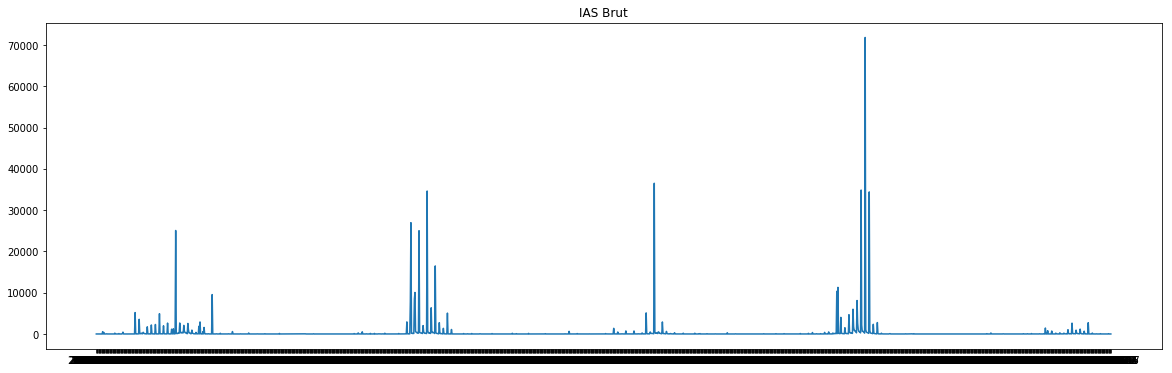

In [8]:
plt.figure(figsize = (20,6))
plt.title("IAS Brut")
plt.plot(x, y)

Commentaire: la série temporelle a des pics annuels.

## EX3

Tracez l’histogramme de la loi marginale. Quel impact la distribution observée par l’histogramme a sur la trajectoire représentée à la question précédente?

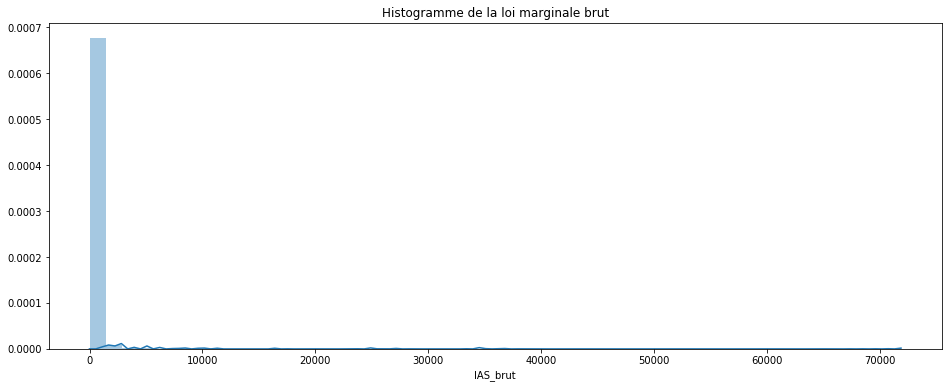

In [9]:
plt.figure(figsize = (16,6))
plt.title("Histogramme de la loi marginale brut")
sns.distplot(data["IAS_brut"])

Commentaire: la distribution des données sont très déséquilibrée, la majorité des données sont entre 0 et 100. Il faudrait faire un traitment pour réduire l'écart entre le minimum et le maximum (logarithme par exemple).

## EX4

Reprenez les questions précédentes après tranformations des observations par le logarithme naturel. Commentez.

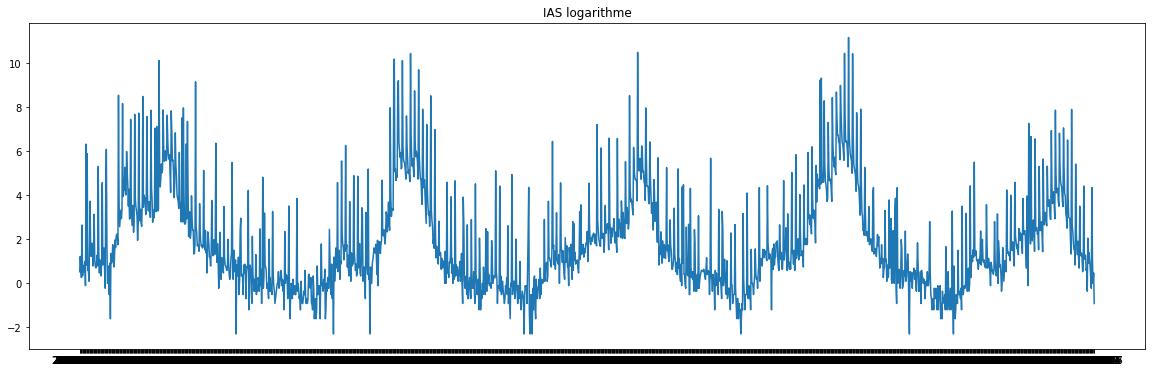

In [10]:
data["log"] = np.log(np.array(data["IAS_brut"]))

x = data["PERIODE"]
y = data["log"]

plt.figure(figsize = (20,6))
plt.title("IAS logarithme")
plt.plot(x, y)

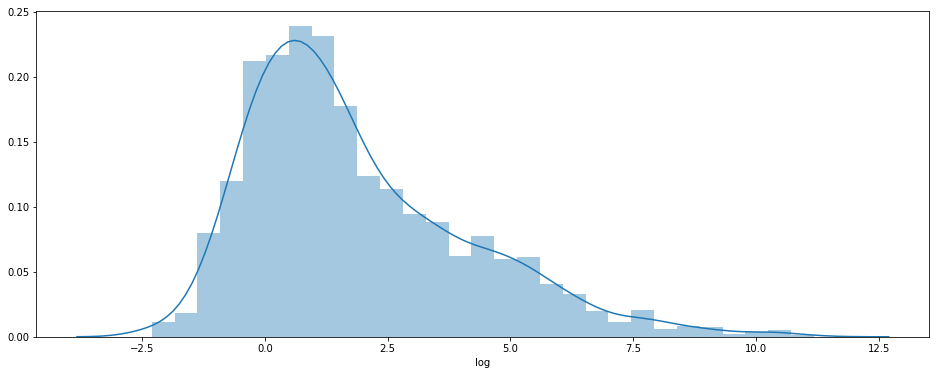

In [11]:
plt.figure(figsize = (16,6))
sns.distplot(y)

Commentaire: après le traitement de logarithme, la distribution des données est plus normalisée.

## EX5

En utilisant signal.periodogram() (du package signal importé depuis scipy), tracez le périodo- gramme des données. Expliquez les pics les plus significatifs que vous observez. 

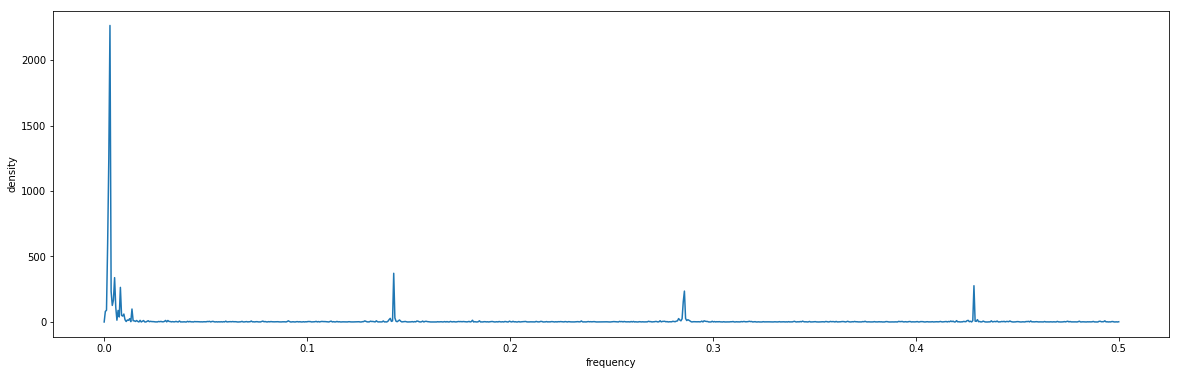

In [12]:
frequence, density = signal.periodogram(data["log"])
plt.figure(figsize=(20,6))
plt.plot(frequence, density)
plt.xlabel('frequency')
plt.ylabel('density')
plt.show()

Commentaire: le premier pic est le plus significatif. Il représente la fréquence annuelle.

## EX6

Utilisez cette méthode pour supprimer la tendance périodique de période 1 an. Quel pic du périodogramme cette méthode a fait disparaître ?

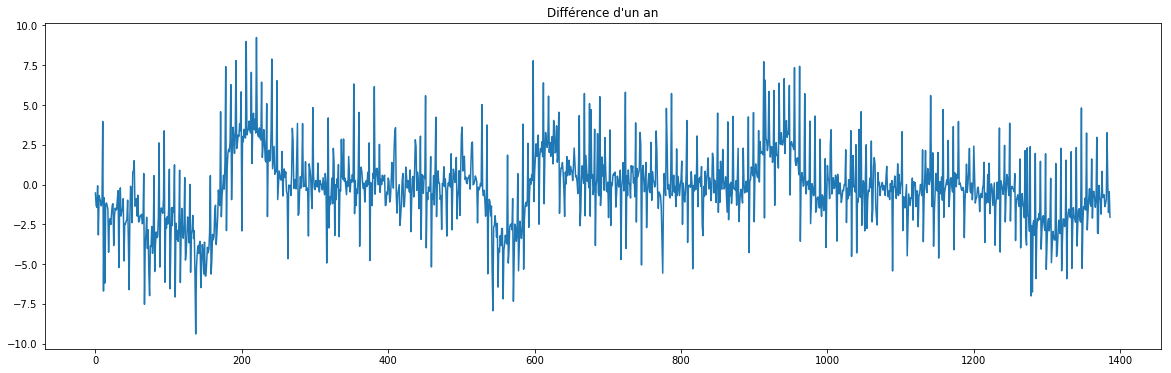

In [13]:
#suppermier la tendance annuelle
time_diff = []
for i in range(365,len(data)):
    time_diff.append(data["log"].iloc[i]-data["log"].iloc[i-365])
    
plt.figure(figsize=(20,6))
plt.plot(time_diff)
plt.title("Différence d'un an")
plt.show()

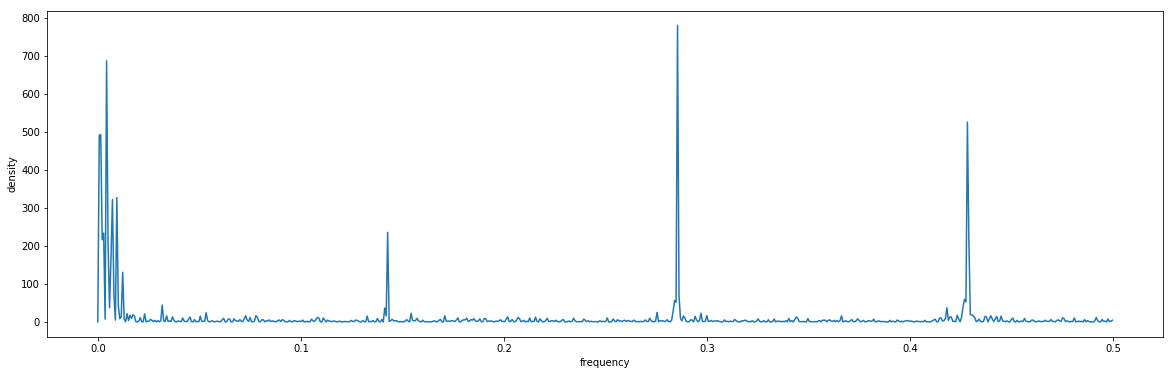

In [14]:
#tracer la courbe périodogramme
f_log, d_log = signal.periodogram(time_diff)
plt.figure(figsize=(20,6))
plt.plot(f_log, d_log)
plt.xlabel('frequency')
plt.ylabel('density')
plt.show()

Réponse: cette méthode a beaucoup réduit le premier pic, qui représente la fréquence annuelle.

## EX7

Tracez les valeur de la série temporelle et votre prédiction pour l’ensemble de données (vous pouvez utilisez les couleurs différentes pour pour les partie apprentissage et prédiction). Puis, donnez le risque quadratique de la prédiction et tracez les résidus pour la période prédite.
Essayez les valeur de n_harm pour voir comment varie le risque quadratique de la prédiction.

In [15]:
def risk_q(data, k):
    data_f = data.copy()
    
    #utiliser les numbres entiers au lieu de dates
    t = data_f.index 
    
    #ajouter les variables explicatives
    for j in range(1,k+1):
        data_f["cos"+str(2*j-1)] = np.cos(t*j*2*np.pi/365)
        data_f["sin"+str(2*j)] = np.sin(t*j*2*np.pi/365)
        
    #séparer train et test   
    data_train = data_f[data_f["PERIODE"] <= "2013-03-31"]
    data_test = data_f[data_f["PERIODE"] > "2013-03-31"]
    
    X_train = data_train.drop(["PERIODE", "IAS_brut", "log"], axis = 1)
    y_train = data_train["log"]
    
    X_test = data_test.drop(["PERIODE", "IAS_brut", "log"], axis = 1)
    y_test = data_test["log"]
    
    #fit avec le train
    reg = LinearRegression().fit(X_train,y_train)
    
    #predict le test
    y_pred = reg.predict(X_test)
    
    #re-indexer la prediction pour tracer la courbe
    index_y_pred = range(len(data_train), len(data_f))
    y_pred = pd.DataFrame(y_pred, index_y_pred)
    
    #tracer la courbe
    plt.figure(figsize=(20,6))
    plt.plot(y_train, label = "train")
    plt.plot(y_pred, label = "prediction")
    plt.plot(y_test, label = "test")
    plt.title("Différence d'un an")
    plt.legend()
    plt.show()
    
    #calculer le risk quadratique
    risk_q = np.average(np.square(np.array(y_pred) - np.array(y_test)))
    print("Le risque quadratique de la prédiction avec n_harm =", k, "est", risk_q)
    return 

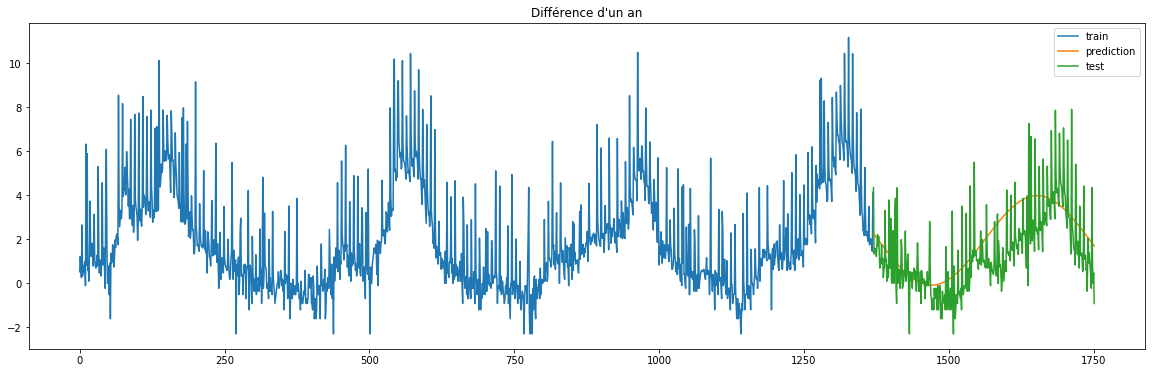

Le risque quadratique de la prédiction avec n_harm = 1 est 5.505507323361709


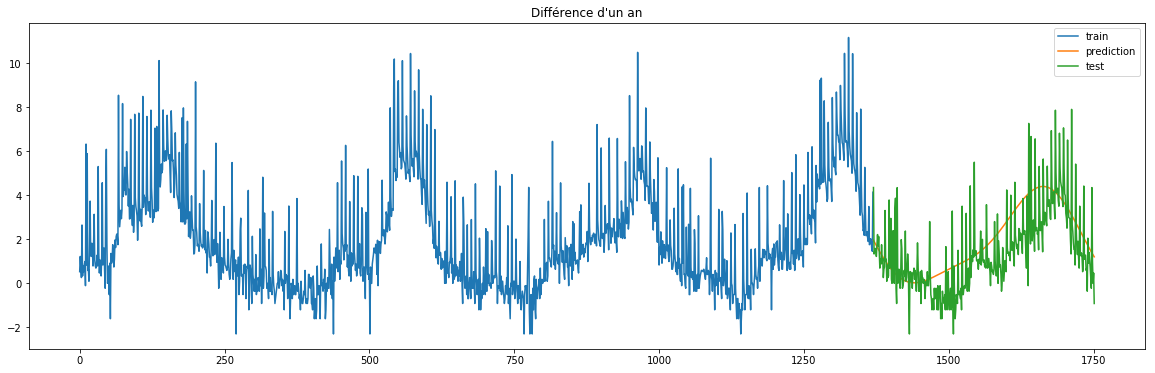

Le risque quadratique de la prédiction avec n_harm = 2 est 5.619859201770467


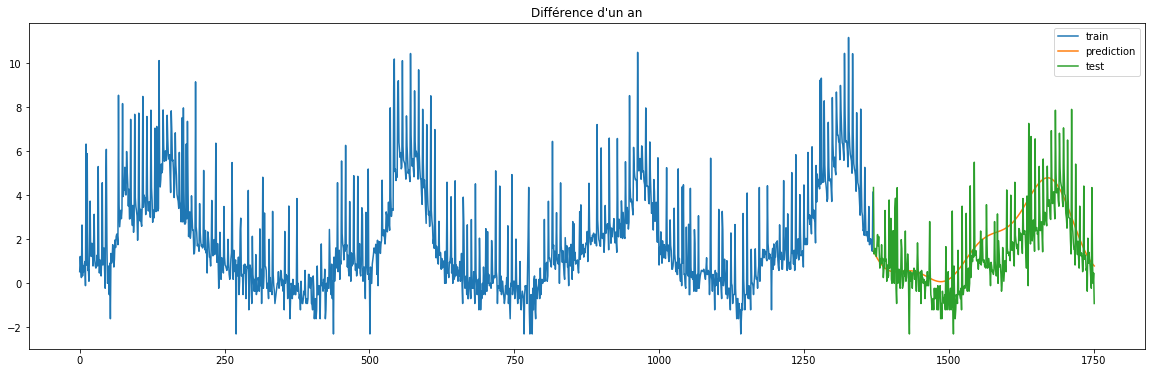

Le risque quadratique de la prédiction avec n_harm = 3 est 5.699115627498395


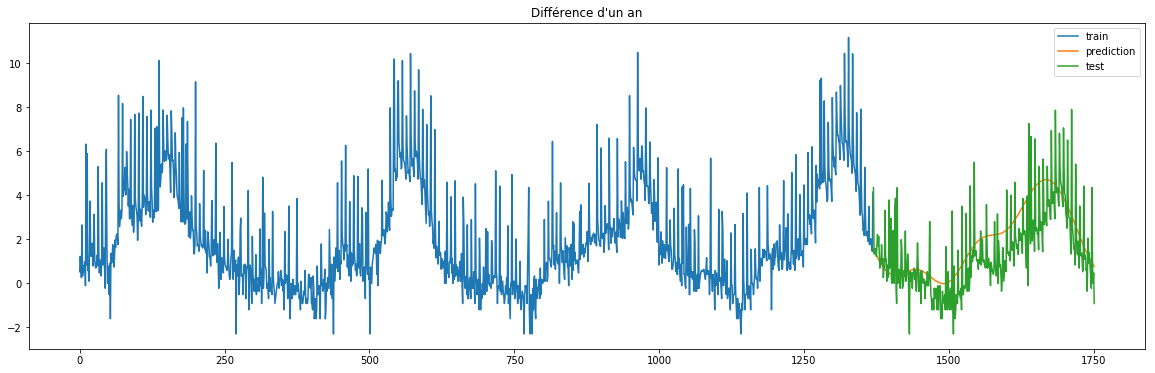

Le risque quadratique de la prédiction avec n_harm = 4 est 5.708042014752831


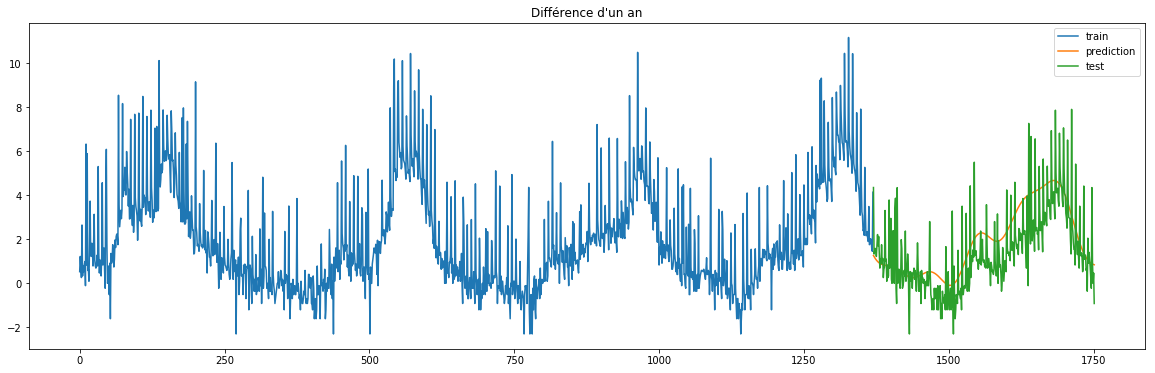

Le risque quadratique de la prédiction avec n_harm = 5 est 5.759617620464916


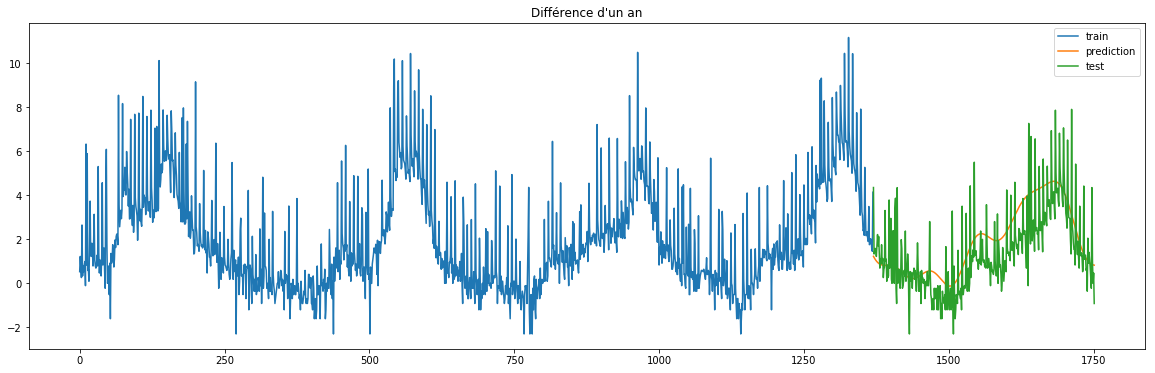

Le risque quadratique de la prédiction avec n_harm = 6 est 5.762239066207667


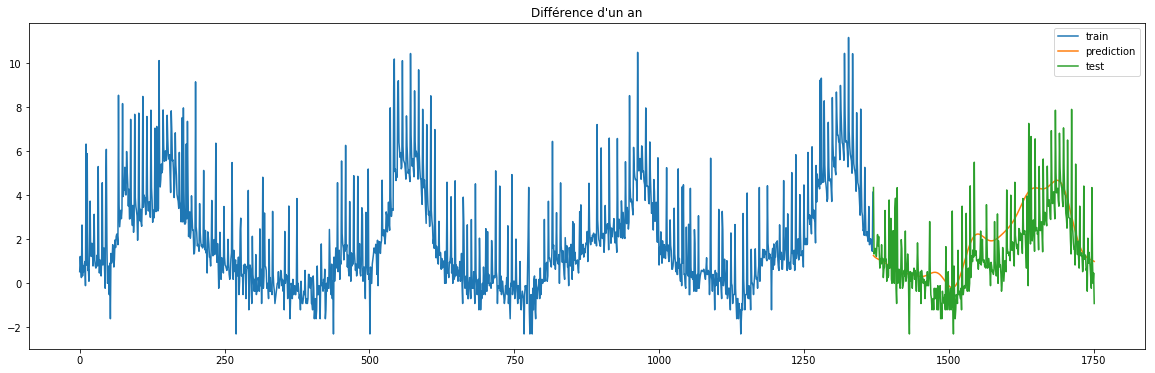

Le risque quadratique de la prédiction avec n_harm = 7 est 5.768423212606426


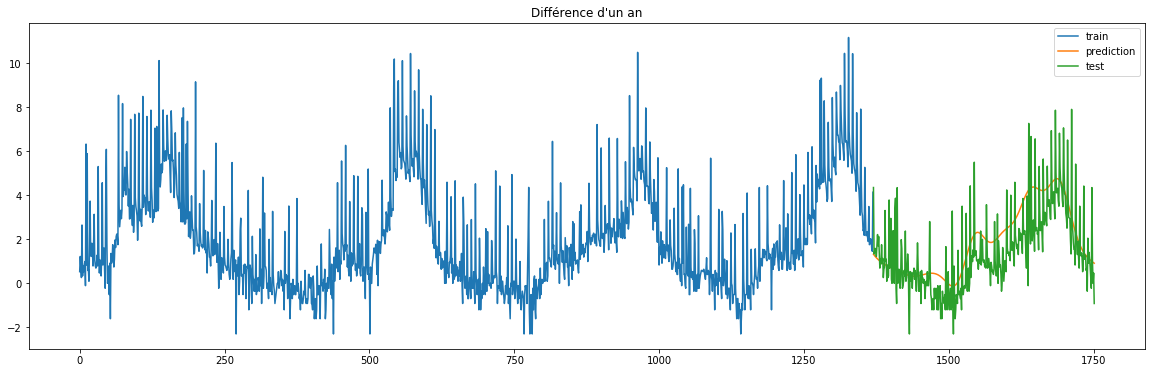

Le risque quadratique de la prédiction avec n_harm = 8 est 5.771986852413231


In [16]:
for k in range(1,9):
    risk_q(data, k)

Commentaire: le risque quadratique atteint son minimun à n_harm = 1.

# Données "Trafic Internet"

## EX8

Importez les données du fichier lbl-tcp-3.tcp. Chaque ligne du tableau correspond à un paquet et la première variable et le moment de sa transmission ; consultez ftp://ita.ee.lbl.gov/html/ contrib/LBL-TCP-3.html pour plus d’information sur les données. Affichez 5 premières lignes du jeu de données.
Tout d’abord, créez la série temporelle, où chaque observation correspond au nombre de paquets transmis dans un intervalle de 10 secondes. Il y a 720 intervalles, donc vous devez obtenir 720 observations.

In [17]:
col = ["timestamp", "sourceHost", "destinationHost", "sourceTCPPort", "destinationTCPPort", "bytes"]
dataint = pd.read_csv("./lbl-tcp-3.tcp", delimiter=" ", encoding="latin-1", names=col)

In [18]:
dataint.head()

,timestamp,sourceHost,destinationHost,sourceTCPPort,destinationTCPPort,bytes
0,7.591038e+08,1,2,23,2436,1
1,1.044500e-02,2,1,2436,23,2
2,2.377500e-02,1,2,23,2436,2
3,2.655800e-02,2,1,2436,23,1
4,2.900200e-02,3,4,3930,119,42


In [19]:
#reset la première valuer de timestamp
dataint["timestamp"].loc[0]=0 

#calculer le nombre de paquet par chaque 10s
package = []
nb = int(round(dataint["timestamp"].iloc[-1]/10))
stop = 0
time = 0
for i in range(nb):
    pac = 0
    time = int((i + 1) * 10)
    for j in range(stop, len(dataint)):
        if dataint.iloc[j]["timestamp"] < time:
            pac = pac + dataint.iloc[j]["bytes"]
        else:
            break
    stop = j
    package.append(pac)

/Users/didi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
print("Il y a bien", len(package),"package.")

Il y a bien 720 package.


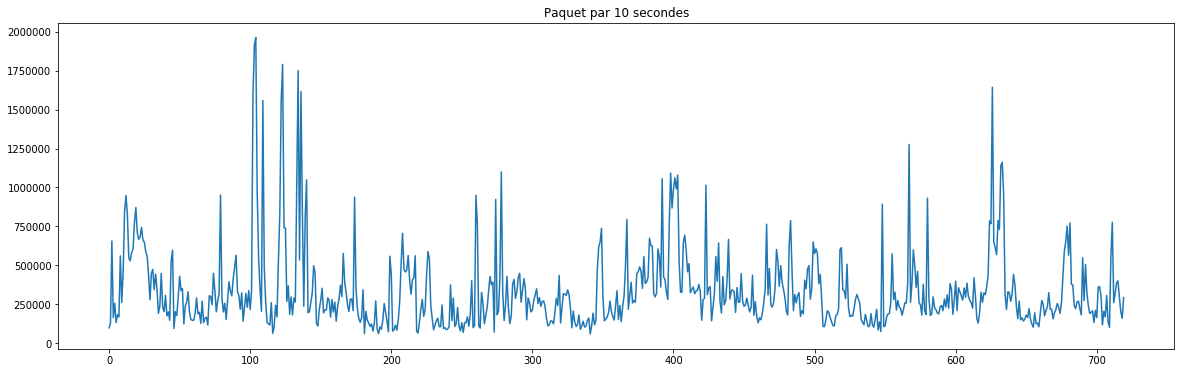

In [21]:
plt.figure(figsize=(20,6))
plt.plot(package)
plt.title("Paquet par 10 secondes")
plt.show()

## EX9 

Dans cette question on vous propose de construire un modèle auto-régressif AR(p). L’apprentissage du modèle ne demande pas beaucoup de temps et s’effectue avec 1 − 2 ligne de code à l’aide de la fonction ARIMA() importée de statsmodels.tsa.arima_model. Le choix du paramètre p (d’une gamme de valeur prédéfinies, disons de 1 à pmax) est moins simple. On va aborder trois possibilité : critère d’information d’Akaike (AIC), critère d’information bayésien (BIC) et validation croisée/backtesting.
<br><br>Le critères d’information AIC et BIC sont normalement implémentés dans le logiciel et sont donnés directement après l’apprentissage du modèle. Pour faire la validation croisée pour une série, on la coupe en nchunks chunks/folds et chaque foi utilise k premiers chunks pour entrainer le modèle et le chunk numéro k + 1 pour le tester (par exemple regarder le risque quadratique).
<br><br>Pour une gamme de valeur choisie, effectue les trois méthodes de la sélection du modèle.

In [22]:
#convertir la format 
package = pd.DataFrame(package)

for p in range(1,5):
    arima = ARIMA(np.asarray(package), order=(p,0,0)).fit(disp=0)
    print("\n\nAvec p égale à", p," \n \n", arima.summary())



Avec p égale à 1  
 
                               ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  720
Model:                     ARMA(1, 0)   Log Likelihood               -9848.238
Method:                       css-mle   S.D. of innovations         210847.065
Date:                Sun, 26 Jan 2020   AIC                          19702.476
Time:                        23:02:33   BIC                          19716.214
Sample:                             0   HQIC                         19707.780
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.39e+05   1.86e+04     18.265      0.000    3.03e+05    3.75e+05
ar.L1.y        0.5774      0.030     18.999      0.000       0.518       0.637
                            

La méthode de validation croisée:

In [23]:
min = float('inf')
for p in range(1,6):
    n = 10
    part = int(len(package)/n)
    risk = []
    for k in range(1, (n-1)):
        #définir train et test
        train = package[:part*k-1]
        test = package[part*k:part*(k+1)]

        #fit modèle
        arima = ARIMA(np.asarray(train), order=(p,0,0)).fit(disp=0)
        pred = arima.predict(start=part*k, end=part*(k+1)-2)
        
        #calculate risk
        risk.append(np.average(np.square(np.asarray(pred) - np.asarray(test))))
        risk_quadratic = np.average(risk)
        if min > risk_quadratic:
            min = risk_quadratic
            min_p = p
        
print("le risque quadratique atteint son minimum",min,"lorsque p est à",p)

le risque quadratique atteint son minimum 78187709877.79752 lorsque p est à 5


Commentaire: 
<br><br>La méthode prévision de ARIMA n'est pas obtimisée avec les paramètres présentes.
<br><br>Toutefois, on peut déduire la valuer de p avec les méthodes AIC et BIC. 
<br><br>AIC pénaliser les modèles en fonction du nombre de paramètres afin de satisfaire le critère de parcimonie. On choisit alors le modèle avec le critère d'information d'Akaike le plus faible. 
<br><br>BIC, à la différence du AIC, la pénalité dépend de la taille de l'échantillon et pas seulement du nombre de paramètres. Le modèle qui sera sélectionné est celui qui minimise le critère BIC.
<br><br>On peut voir que AIC atteint son minimum lorsque p = 2, et BIC atteint son minimum lorsque p = 1. Comme BIC pénalise plus que AIC lorsque le nombre de données est grand, BIC tendence à préférer une modèle plus simple que AIC. On regarde donc Log Likelihood, lorsque p=2 il attaint son minimum. Donc en conclusion, on choisit p = 2.

## EX10

En ce basant sur les résultats de la question précédente, sélectionnez l’ordre p du modèle AR à estimer et affichez les paramètres correspondants.
Tracez les résidus. Tracez l’estimation de la densité de résidus et la densité de la distribution
normale (avec moyenne et écart-type estimés) sur le même graphique et comparez les visuellement. Commentez.

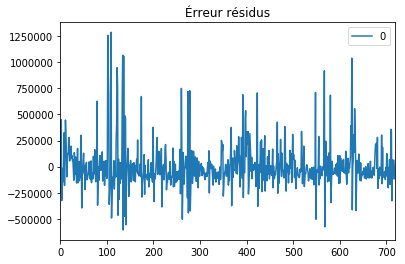

                  0
count  7.200000e+02
mean  -4.293224e+01
std    2.103699e+05
min   -6.067588e+05
25%   -1.029585e+05
50%   -3.541781e+04
75%    5.383496e+04
max    1.288215e+06


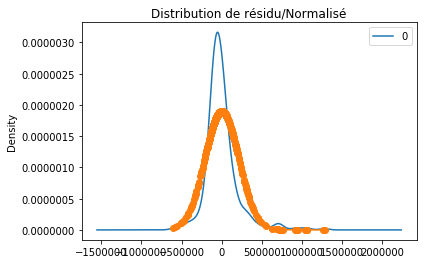

In [24]:
#fit modèle avec p=2
p=2
arima_perf = ARIMA(np.asarray(package), order=(p,0,0)).fit(disp=0)

#plot erreurs résiduelles
residuals = pd.DataFrame(arima_perf.resid)
residuals.plot()
plt.title("Érreur résidus")
plt.show()
print(residuals.describe())

res_sort = residuals.sort_values(0)
fit = norm.pdf(res_sort, np.mean(res_sort), np.std(res_sort))
residuals.plot(kind='kde')
plt.plot(res_sort, fit,'-o')
plt.title("Distribution de résidu/Normalisé")
plt.show()

Commentaire: le centre de la distribution de résidus normalisée est plus proche de zéro, et ses résidus sont plus répartis entre -500000 et 500000. <br>La modèle est légèrement biaisée, et il existerait possiblement une potentiel de over-fitting.

## EX11

Importez les données du fichier soi.tsv. Consultez http://www.bom.gov.au/climate/glossary/ soi.shtml pour plus d’information sur les données. Supprimez les données manquantes.

In [25]:
datasoi = pd.read_csv("soi.tsv", delimiter="\t", header=None).T

In [26]:
datasoi = datasoi.dropna()
datasoi

,0
0,1.537160
1,0.922168
2,-0.104204
3,-0.291903
4,-0.658745
...,...
775,-1.423410
776,-1.630080
777,-1.699540
778,-0.502287


## EX12

Al’aide des fonctions plot_acf( ) et plot_pacf( ) importées de statsmodels.graphics.tsaplots, tracez la fonction d’autocorrélation et la fonction d’autocorrélation partielle.

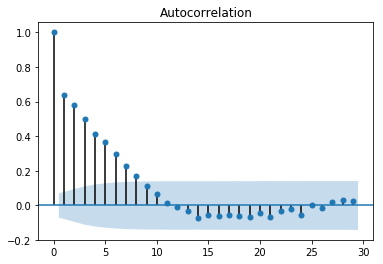

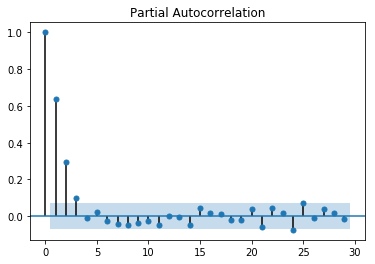

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
acf = plot_acf(datasoi)
pacf = plot_pacf(datasoi)

Commentaire: d'après PACF, la donnée actuelle dépend des 4 données précédentes. Donc on prend p = 4.

## EX13

En ce basant sur la question précédente, choisissez l’ordre du processus auto-régressive AR(p). Entrainer le modèle AR choisi. Tracez les résidus. Tracez l’estimation de la densité de résidus et la densité de la distribution normale (avec moyenne et écart-type estimés) sur le même graphique et comparez les visuellement. Commentez.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  780
Model:                     ARMA(4, 0)   Log Likelihood                -821.290
Method:                       css-mle   S.D. of innovations              0.693
Date:                Sun, 26 Jan 2020   AIC                           1654.579
Time:                        23:02:37   BIC                           1682.535
Sample:                             0   HQIC                          1665.331
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1288      0.106      1.214      0.225      -0.079       0.337
ar.L1.y        0.4226      0.036     11.793      0.000       0.352       0.493
ar.L2.y        0.2530      0.039      6.531      0.0

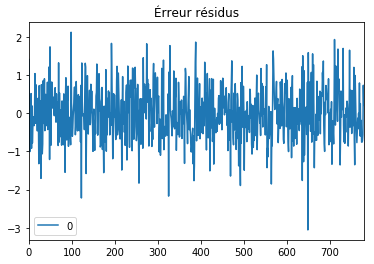

                0
count  780.000000
mean    -0.002198
std      0.694478
min     -3.058077
25%     -0.479530
50%     -0.007303
75%      0.442304
max      2.123565


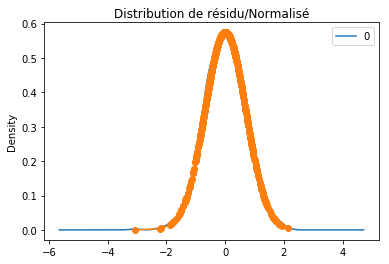

In [28]:
# fit model
p = 4
arima_soi = ARIMA(np.asarray(datasoi), order=(p,0,0)).fit(disp=0)
print(arima_soi.summary())

#plot erreurs résiduelles
residuals = pd.DataFrame(arima_soi.resid)
residuals.plot()
plt.title("Érreur résidus")
plt.show()
print(residuals.describe())

res_sort = residuals.sort_values(0)
fit = norm.pdf(res_sort, np.mean(res_sort), np.std(res_sort))
residuals.plot(kind='kde')
plt.plot(res_sort, fit,'-o')
plt.title("Distribution de résidu/Normalisé")
plt.show()

Commentaire: la distribution de résidu et celle normalisée se recouvrent. On peut en déduire que c'est l'érreur aléatoire. La modèle n'est pas biaisée.

## EX14

Tracez le périodogramme; superposez le à la densité spectrale du modèle estimé à la question précédente.

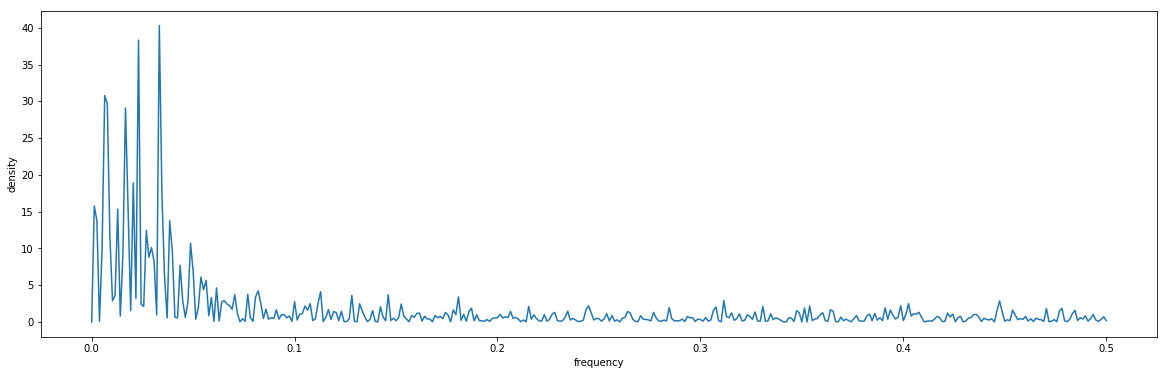

In [29]:
f_soi, d_soi = signal.periodogram(datasoi[0])
plt.figure(figsize=(20,6))
plt.plot(f_soi, d_soi)
plt.xlabel('frequency')
plt.ylabel('density')
plt.show()